In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [49]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [50]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
989   0.600856  0.853466  0.762390  0.167518  0.857974  0.311160  0.289533   
774   0.170246  0.961474  0.814104  0.195922  0.863629  0.524464  0.278050   
788   0.165540  0.958782  0.855044  0.200355  0.850990  0.577240  0.371423   
2058  0.169989  0.858513  0.879530  0.250355  0.867953  0.524189  0.462538   
1519  0.336043  0.879542  0.719295  0.444326  0.892233  0.446949  0.956890   
...        ...       ...       ...       ...       ...       ...       ...   
1895  0.337326  0.936070  0.664251  0.205674  0.721437  0.318032  0.272967   
617   0.134481  0.926144  0.923213  0.280674  0.905205  0.625344  0.760919   
1049  0.116727  0.977288  0.966699  0.345035  0.986030  0.711380  0.970068   
741   0.155358  0.903264  0.859941  0.196454  0.834193  0.486806  0.353727   
1949  0.118802  0.968708  0.806072  0.261879  0.913188  0.597306  0.428652   

            F9        F5      F7      F12      F8  
989   0.224

In [51]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


# Call the Encoder pkl file

In [52]:
import pickle

# Load the encoder model from the saved file
with open("all_pkl_file/Encoder_3.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [53]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



70/70 [==============================] - 0s 811us/step


21/21 [==============================] - 0s 1ms/step


# tune the Encoder file

In [54]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler(copy=True).fit(dataset)
encoded_X_n=scaler.transform(dataset)
encoded_X_train_n=scaler.transform(X_train)
encoded_X_test_n=scaler.transform(X_test)
encoded_X_train_n

array([[0.75144385, 0.82907133, 0.582762  , ..., 0.15870809, 0.27085   ,
        0.12518766],
       [0.15223529, 0.88711306, 0.80901077, ..., 0.14971382, 0.04242   ,
        0.3145955 ],
       [0.17886631, 0.97711978, 0.83643487, ..., 0.51349141, 0.28155   ,
        0.6088407 ],
       ...,
       [0.17572193, 0.95373486, 0.89598433, ..., 0.2420278 , 0.03894   ,
        0.32477064],
       [0.13264171, 0.97072678, 0.95984329, ..., 0.69828291, 0.028075  ,
        0.67706422],
       [0.21882353, 0.96113728, 0.79294809, ..., 0.1656991 , 0.2689    ,
        0.1618849 ]])

In [55]:
# train the model with random parameter

# Preparing the regressor and fitting data with some parameters
import xgboost


xg_reg = xgboost.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 1, 
                          learning_rate = 0.3,
                          max_depth = 15, 
                          alpha = 10, 
                          n_estimators = 100, 
                          verbose=1, 
                          min_child_weight = 1, 
                          colsample_bylevel = 1, 
                          reg_alpha = 2) 

xg_reg.fit(encoded_X_train_n, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [56]:
# Finding mean absolute error
preds = xg_reg.predict(encoded_X_test_n)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.3102409638554217

In [57]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(encoded_X_n)
target_train_tunned = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(encoded_X_n)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [1e-5,1e-4,1e-3,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.04,0.08,0.12,0.20, 0.24, 0.30, 0.38, 0.42, 0.48, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]),
            'n_estimators': trial.suggest_int('n_estimators', 1, 300),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20,25,30,35,40]),
            'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
    model = xgboost.XGBRegressor(**param)  
        
    model.fit(train_X,train_Y,eval_set=[(valid_X,valid_Y)],early_stopping_rounds=100,verbose=False)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [58]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study = optuna.create_study(direction='minimize',study_name="XG_tune")

[I 2024-02-12 13:38:48,418] A new study created in memory with name: XG_tune


In [59]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-12 13:38:48,625] Trial 0 finished with value: 0.6388198025457251 and parameters: {'lambda': 0.0708595845683355, 'alpha': 0.8940158112300501, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.6, 'learning_rate': 0.003, 'n_estimators': 23, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 119}. Best is trial 0 with value: 0.6388198025457251.


2212


[I 2024-02-12 13:38:49,634] Trial 1 finished with value: 0.49276779935599235 and parameters: {'lambda': 0.12227069174603296, 'alpha': 0.0012032722334979404, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.3, 'subsample': 0.6, 'learning_rate': 0.004, 'n_estimators': 139, 'max_depth': 30, 'random_state': 2020, 'min_child_weight': 47}. Best is trial 1 with value: 0.49276779935599235.


2212


[I 2024-02-12 13:38:50,496] Trial 2 finished with value: 0.18907723538295465 and parameters: {'lambda': 0.3847301677557708, 'alpha': 0.010110133523103196, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'subsample': 0.6, 'learning_rate': 0.12, 'n_estimators': 179, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 184}. Best is trial 2 with value: 0.18907723538295465.


2212


[I 2024-02-12 13:38:51,650] Trial 3 finished with value: 0.2136347858710164 and parameters: {'lambda': 2.2415674976407014, 'alpha': 0.04783334548201795, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 187, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 88}. Best is trial 2 with value: 0.18907723538295465.


2212


[I 2024-02-12 13:38:52,507] Trial 4 finished with value: 0.3660629074112702 and parameters: {'lambda': 0.010950911036033038, 'alpha': 4.48414140212368, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 0.12, 'n_estimators': 201, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 236}. Best is trial 2 with value: 0.18907723538295465.


2212


[I 2024-02-12 13:38:53,277] Trial 5 finished with value: 0.5823477097596657 and parameters: {'lambda': 0.002297226398584721, 'alpha': 0.0012427039363125177, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.002, 'n_estimators': 180, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 214}. Best is trial 2 with value: 0.18907723538295465.


2212


[I 2024-02-12 13:38:54,440] Trial 6 finished with value: 0.43917995708140717 and parameters: {'lambda': 1.5197692210818967, 'alpha': 0.01626129329500049, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.006, 'n_estimators': 261, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 169}. Best is trial 2 with value: 0.18907723538295465.


2212


[I 2024-02-12 13:38:56,066] Trial 7 finished with value: 0.1630314151916668 and parameters: {'lambda': 0.9458836735906693, 'alpha': 0.0011795999137002228, 'colsample_bytree': 0.3, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 1.0, 'n_estimators': 269, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 130}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:38:56,919] Trial 8 finished with value: 0.1868173054604028 and parameters: {'lambda': 0.0010225183607214306, 'alpha': 0.0036997564186821105, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.3, 'subsample': 0.6, 'learning_rate': 0.48, 'n_estimators': 191, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 222}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:38:58,394] Trial 9 finished with value: 0.2640207628525834 and parameters: {'lambda': 0.024801248775210526, 'alpha': 0.15233956970234505, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.8, 'learning_rate': 0.007, 'n_estimators': 209, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 115}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:39:00,410] Trial 10 finished with value: 0.2721963598987401 and parameters: {'lambda': 6.8614299139006185, 'alpha': 0.30195494931943795, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 299, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 297}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:39:01,249] Trial 11 finished with value: 0.19764595177987923 and parameters: {'lambda': 0.0037587553470082645, 'alpha': 0.00573974227175102, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 1.0, 'n_estimators': 113, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 269}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:39:04,349] Trial 12 finished with value: 0.17477032095366485 and parameters: {'lambda': 0.8278238633711666, 'alpha': 0.004076366344280441, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.48, 'n_estimators': 253, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 5}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:39:06,443] Trial 13 finished with value: 0.24724978157754895 and parameters: {'lambda': 0.5980022090206379, 'alpha': 0.02536537251453338, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 1.0, 'n_estimators': 257, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 15}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:39:09,227] Trial 14 finished with value: 0.18687213172286032 and parameters: {'lambda': 0.3172911910001718, 'alpha': 0.002426575531254166, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.48, 'n_estimators': 255, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 3}. Best is trial 7 with value: 0.1630314151916668.


2212


[I 2024-02-12 13:39:12,563] Trial 15 finished with value: 0.08789435133373723 and parameters: {'lambda': 9.723749542594971, 'alpha': 0.004999842698323477, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.6, 'n_estimators': 299, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 70}. Best is trial 15 with value: 0.08789435133373723.


2212


[I 2024-02-12 13:39:15,979] Trial 16 finished with value: 0.08687730644144855 and parameters: {'lambda': 8.09475558799267, 'alpha': 0.054527058551451776, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.6, 'n_estimators': 299, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 68}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:19,042] Trial 17 finished with value: 0.10296383740992587 and parameters: {'lambda': 9.748717373790342, 'alpha': 0.058927653176908755, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.6, 'n_estimators': 299, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 67}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:19,923] Trial 18 finished with value: 0.11326094060772264 and parameters: {'lambda': 4.656476717138163, 'alpha': 0.5804434760396526, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.5, 'learning_rate': 0.6, 'n_estimators': 75, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 49}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:21,958] Trial 19 finished with value: 0.6691206235027658 and parameters: {'lambda': 2.8792213320940014, 'alpha': 6.858806611447158, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 1e-05, 'n_estimators': 225, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 74}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:25,228] Trial 20 finished with value: 0.0927364870294301 and parameters: {'lambda': 0.18309409190278197, 'alpha': 0.03302006761132887, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.6, 'n_estimators': 300, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 99}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:28,454] Trial 21 finished with value: 0.09723783160429209 and parameters: {'lambda': 0.1256134211528914, 'alpha': 0.029572257917881716, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.6, 'n_estimators': 300, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 98}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:30,495] Trial 22 finished with value: 0.10104891355275758 and parameters: {'lambda': 3.313312123742008, 'alpha': 0.11717680113509758, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.6, 'n_estimators': 228, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 144}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:33,988] Trial 23 finished with value: 0.10628017430816533 and parameters: {'lambda': 9.063583366975122, 'alpha': 0.009889500732246254, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.7, 'n_estimators': 274, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 36}. Best is trial 16 with value: 0.08687730644144855.


2212


[I 2024-02-12 13:39:36,414] Trial 24 finished with value: 0.08402032717354226 and parameters: {'lambda': 0.04594458964396375, 'alpha': 0.06051257636519631, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.3, 'n_estimators': 232, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 101}. Best is trial 24 with value: 0.08402032717354226.


2212


[I 2024-02-12 13:39:38,283] Trial 25 finished with value: 0.10551900787347006 and parameters: {'lambda': 0.05282219099722732, 'alpha': 1.683427122262778, 'colsample_bytree': 0.4, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.3, 'n_estimators': 239, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 63}. Best is trial 24 with value: 0.08402032717354226.


2212


[I 2024-02-12 13:39:40,576] Trial 26 finished with value: 0.09842356479523899 and parameters: {'lambda': 0.02243804276254056, 'alpha': 0.22308160951007178, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.3, 'n_estimators': 277, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 161}. Best is trial 24 with value: 0.08402032717354226.


2212


[I 2024-02-12 13:39:41,906] Trial 27 finished with value: 0.18000927787323803 and parameters: {'lambda': 0.00884347530302874, 'alpha': 0.07800427767327255, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'subsample': 0.4, 'learning_rate': 0.8, 'n_estimators': 159, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 88}. Best is trial 24 with value: 0.08402032717354226.


2212


[I 2024-02-12 13:39:44,389] Trial 28 finished with value: 0.553414553188286 and parameters: {'lambda': 0.04020935287018129, 'alpha': 0.013457882574280716, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 227, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 35}. Best is trial 24 with value: 0.08402032717354226.


2212


[I 2024-02-12 13:39:44,763] Trial 29 finished with value: 0.5831974291564328 and parameters: {'lambda': 1.506167088053389, 'alpha': 0.5126160870157053, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 21, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 111}. Best is trial 24 with value: 0.08402032717354226.


2212


[I 2024-02-12 13:39:45,425] Trial 30 finished with value: 0.16267695834546642 and parameters: {'lambda': 0.29489612432822465, 'alpha': 1.6151171017442594, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.2, 'n_estimators': 64, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 130}. Best is trial 24 with value: 0.08402032717354226.


2212


[I 2024-02-12 13:39:48,793] Trial 31 finished with value: 0.07639696643862039 and parameters: {'lambda': 0.18859879428483453, 'alpha': 0.03717802947438325, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 300, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 93}. Best is trial 31 with value: 0.07639696643862039.


2212


[I 2024-02-12 13:39:52,696] Trial 32 finished with value: 0.06794079326129353 and parameters: {'lambda': 0.09216607068087122, 'alpha': 0.05783375724034503, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 280, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 64}. Best is trial 32 with value: 0.06794079326129353.


2212


[I 2024-02-12 13:39:57,962] Trial 33 finished with value: 0.05545381337332899 and parameters: {'lambda': 0.10838562346002595, 'alpha': 0.07935940856059678, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 279, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 27}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:02,388] Trial 34 finished with value: 0.0772770105003709 and parameters: {'lambda': 0.08442179985711643, 'alpha': 0.13216626065573925, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 278, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 28}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:05,904] Trial 35 finished with value: 0.08863609163097429 and parameters: {'lambda': 0.09169814175345892, 'alpha': 0.16881756736825587, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'subsample': 0.6, 'learning_rate': 0.08, 'n_estimators': 277, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 31}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:10,255] Trial 36 finished with value: 0.07753827685288116 and parameters: {'lambda': 0.16602081582995715, 'alpha': 0.32737249800947654, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 279, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 24}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:12,385] Trial 37 finished with value: 0.1175823498759309 and parameters: {'lambda': 0.07519038358454541, 'alpha': 0.01977223061278324, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'subsample': 0.4, 'learning_rate': 0.08, 'n_estimators': 245, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 54}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:13,996] Trial 38 finished with value: 0.10155494461943051 and parameters: {'lambda': 0.2071121350661228, 'alpha': 0.09169953865163623, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 139, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 81}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:16,344] Trial 39 finished with value: 0.10024360108136814 and parameters: {'lambda': 0.011390748348516343, 'alpha': 0.03448132514545585, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.42, 'n_estimators': 207, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 51}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:16,557] Trial 40 finished with value: 0.25712978478544685 and parameters: {'lambda': 0.44510293327349665, 'alpha': 0.008676113990677227, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.6, 'learning_rate': 0.9, 'n_estimators': 5, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 187}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:20,818] Trial 41 finished with value: 0.08016309059339832 and parameters: {'lambda': 0.1591368473574476, 'alpha': 0.3914376503975379, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 274, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 22}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:24,112] Trial 42 finished with value: 0.08163908286121918 and parameters: {'lambda': 0.029067705680351892, 'alpha': 1.0852300468946348, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.08, 'n_estimators': 282, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 22}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:27,501] Trial 43 finished with value: 0.6564165852815721 and parameters: {'lambda': 0.09246743517197345, 'alpha': 0.24899932891925683, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.0001, 'n_estimators': 285, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 36}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:29,874] Trial 44 finished with value: 0.06321157824792285 and parameters: {'lambda': 0.2557084962222195, 'alpha': 0.15094551169420878, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.04, 'n_estimators': 260, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 13}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:32,069] Trial 45 finished with value: 0.07098603497789517 and parameters: {'lambda': 0.24240292430724472, 'alpha': 0.1558861869720331, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.04, 'n_estimators': 246, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 2}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:34,369] Trial 46 finished with value: 0.09891509353540034 and parameters: {'lambda': 0.4623695648686198, 'alpha': 0.09536533935627954, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 261, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 5}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:36,677] Trial 47 finished with value: 0.07866811472490348 and parameters: {'lambda': 0.24332269056517286, 'alpha': 0.19348953794473925, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.4, 'learning_rate': 0.04, 'n_estimators': 250, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 1}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:38,229] Trial 48 finished with value: 0.5831219311971992 and parameters: {'lambda': 0.8426381091176165, 'alpha': 0.05024034302044532, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 190, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 43}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:41,652] Trial 49 finished with value: 0.1100745049606719 and parameters: {'lambda': 1.2351664456533797, 'alpha': 0.020067218360388734, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.5, 'n_estimators': 264, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 16}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:43,406] Trial 50 finished with value: 0.317700364679152 and parameters: {'lambda': 0.6156556069398732, 'alpha': 0.07787892728064633, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.005, 'n_estimators': 215, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 57}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:46,054] Trial 51 finished with value: 0.05937205078133715 and parameters: {'lambda': 0.06249025479959287, 'alpha': 0.12259126693641081, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 290, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 14}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:48,814] Trial 52 finished with value: 0.060059785470816786 and parameters: {'lambda': 0.13096511006929185, 'alpha': 0.03653504138601289, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 288, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 14}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:51,181] Trial 53 finished with value: 0.061049002832670334 and parameters: {'lambda': 0.12974014177269666, 'alpha': 0.12691695030384972, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 246, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 13}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:53,850] Trial 54 finished with value: 0.062025585383367506 and parameters: {'lambda': 0.12075604944196477, 'alpha': 0.11351501508822018, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 290, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 13}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:56,337] Trial 55 finished with value: 0.07360457019494064 and parameters: {'lambda': 0.1296603440463814, 'alpha': 0.12389665570148461, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.24, 'n_estimators': 267, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 14}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:40:58,493] Trial 56 finished with value: 0.07516772042353827 and parameters: {'lambda': 0.05285260756035063, 'alpha': 0.573221359831737, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 288, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 40}. Best is trial 33 with value: 0.05545381337332899.


2212


[I 2024-02-12 13:41:03,379] Trial 57 finished with value: 0.05478524775742429 and parameters: {'lambda': 0.034677571539143665, 'alpha': 0.04279485799897986, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 289, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 12}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:08,086] Trial 58 finished with value: 0.07642505459843105 and parameters: {'lambda': 0.018497864290359017, 'alpha': 0.02451212982424031, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.5, 'learning_rate': 0.24, 'n_estimators': 239, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 11}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:12,462] Trial 59 finished with value: 0.07379573046450401 and parameters: {'lambda': 0.03234725579754016, 'alpha': 0.04182907577356336, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 290, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 48}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:14,544] Trial 60 finished with value: 0.4122921435084955 and parameters: {'lambda': 0.06374892103927461, 'alpha': 0.013414126354434518, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.003, 'n_estimators': 291, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 248}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:16,915] Trial 61 finished with value: 0.06528206148145785 and parameters: {'lambda': 0.016103121407051123, 'alpha': 0.08207407024471154, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 260, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 18}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:21,365] Trial 62 finished with value: 0.09260568597031274 and parameters: {'lambda': 0.11409488453935988, 'alpha': 0.12008017897250205, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 267, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 11}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:23,680] Trial 63 finished with value: 0.29383055735076313 and parameters: {'lambda': 0.03653792347710903, 'alpha': 0.2816872919450611, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.004, 'n_estimators': 254, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 12}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:25,437] Trial 64 finished with value: 0.06821050491305516 and parameters: {'lambda': 0.06021088165735871, 'alpha': 0.4117443520016871, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 116, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 27}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:28,249] Trial 65 finished with value: 0.06889184125005242 and parameters: {'lambda': 0.1326703679981558, 'alpha': 0.06932680142047841, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.12, 'n_estimators': 290, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 41}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:32,087] Trial 66 finished with value: 0.07366033340941772 and parameters: {'lambda': 0.36063098516549136, 'alpha': 0.18242204121775707, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.24, 'n_estimators': 268, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 28}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:33,865] Trial 67 finished with value: 0.5511519812842389 and parameters: {'lambda': 0.2682001307067951, 'alpha': 0.04619166515376128, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'subsample': 1.0, 'learning_rate': 0.002, 'n_estimators': 238, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 194}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:36,262] Trial 68 finished with value: 0.5611110277352669 and parameters: {'lambda': 0.04408247192921566, 'alpha': 0.02657392645028211, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 217, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 9}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:38,039] Trial 69 finished with value: 0.2508812678226726 and parameters: {'lambda': 0.003776707251342676, 'alpha': 0.1154093368299676, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.007, 'n_estimators': 173, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 32}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:41,091] Trial 70 finished with value: 0.527075120596515 and parameters: {'lambda': 0.06363601897447073, 'alpha': 0.21735154478890736, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 290, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 20}. Best is trial 57 with value: 0.05478524775742429.


2212


[I 2024-02-12 13:41:43,253] Trial 71 finished with value: 0.053511219671800295 and parameters: {'lambda': 0.015302089803318148, 'alpha': 0.08209046136876601, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 258, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 1}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:41:45,806] Trial 72 finished with value: 0.188997367413792 and parameters: {'lambda': 0.006512776626145289, 'alpha': 0.06443099898738067, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.006, 'n_estimators': 271, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 1}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:41:48,013] Trial 73 finished with value: 0.5410215740393558 and parameters: {'lambda': 0.024567812711257006, 'alpha': 0.10565875035727808, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 255, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 22}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:41:50,706] Trial 74 finished with value: 0.5174187538475068 and parameters: {'lambda': 0.013836187278479675, 'alpha': 0.14867852677027668, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 293, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 10}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:41:51,939] Trial 75 finished with value: 0.06895488444891831 and parameters: {'lambda': 0.1508158934207004, 'alpha': 0.04018811783259152, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 63, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 44}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:41:55,555] Trial 76 finished with value: 0.527331267596369 and parameters: {'lambda': 0.006295259908329311, 'alpha': 0.054796223231401354, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 282, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 33}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:41:57,148] Trial 77 finished with value: 0.613294856080526 and parameters: {'lambda': 0.10556527939184471, 'alpha': 0.08422405042808745, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 247, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 294}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:00,026] Trial 78 finished with value: 0.09193959685023712 and parameters: {'lambda': 0.078192416134317, 'alpha': 0.03431725004751204, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 0.5, 'learning_rate': 0.24, 'n_estimators': 274, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 58}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:02,612] Trial 79 finished with value: 0.5449932932206993 and parameters: {'lambda': 0.01981568434166764, 'alpha': 0.15977719228742865, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 260, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 78}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:04,313] Trial 80 finished with value: 0.28184416748677626 and parameters: {'lambda': 0.19954360614149477, 'alpha': 0.0015875568081760918, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 198, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 18}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:06,673] Trial 81 finished with value: 0.06454057277970715 and parameters: {'lambda': 0.014753047922213396, 'alpha': 0.08756087375104012, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 262, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 17}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:09,298] Trial 82 finished with value: 0.5261102951456798 and parameters: {'lambda': 0.026682436102479508, 'alpha': 0.09298223152700973, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 283, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 1}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:12,557] Trial 83 finished with value: 0.544967122928359 and parameters: {'lambda': 0.009854094230828205, 'alpha': 0.06800055938086773, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 237, 'max_depth': 40, 'random_state': 24, 'min_child_weight': 26}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:15,184] Trial 84 finished with value: 0.5217193663659191 and parameters: {'lambda': 0.046865019511047164, 'alpha': 0.049480077661669564, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 295, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 9}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:18,205] Trial 85 finished with value: 0.5312897409388213 and parameters: {'lambda': 0.013425883363736263, 'alpha': 0.30751544750382975, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 275, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 36}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:20,603] Trial 86 finished with value: 0.5332236777162466 and parameters: {'lambda': 0.03516092602800092, 'alpha': 0.21706210503926823, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 264, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 19}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:25,026] Trial 87 finished with value: 0.532992974462604 and parameters: {'lambda': 0.07267067763966656, 'alpha': 0.13820909556760796, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 249, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 6}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:27,451] Trial 88 finished with value: 0.5378234694437352 and parameters: {'lambda': 0.00835520086167504, 'alpha': 0.021532147050694412, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.3, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 300, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 28}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:29,598] Trial 89 finished with value: 0.09848378376745695 and parameters: {'lambda': 0.1032392389988335, 'alpha': 0.8070824779068055, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 0.4, 'learning_rate': 0.24, 'n_estimators': 221, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 50}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:33,331] Trial 90 finished with value: 0.6684716628429903 and parameters: {'lambda': 0.5308209695476743, 'alpha': 0.10220361902430405, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 1e-05, 'n_estimators': 286, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 16}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:35,638] Trial 91 finished with value: 0.06520142335604667 and parameters: {'lambda': 0.01989929173892316, 'alpha': 0.07348949336412687, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 257, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 17}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:37,636] Trial 92 finished with value: 0.5531573438946205 and parameters: {'lambda': 0.0208691316656622, 'alpha': 0.0767942507689138, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 233, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 36}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:39,995] Trial 93 finished with value: 0.05772024572130252 and parameters: {'lambda': 0.31771131189441437, 'alpha': 0.060707088863003446, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 270, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 8}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:42,316] Trial 94 finished with value: 0.5438869280797879 and parameters: {'lambda': 0.22262766915102958, 'alpha': 0.031083201363368354, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 270, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 6}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:45,018] Trial 95 finished with value: 0.06438027076322199 and parameters: {'lambda': 0.3167052782481812, 'alpha': 0.05530853601263451, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 282, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 25}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:47,556] Trial 96 finished with value: 0.08018120916767492 and parameters: {'lambda': 0.3818227342971211, 'alpha': 0.053202394209676644, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.7, 'n_estimators': 277, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 23}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:50,769] Trial 97 finished with value: 0.5242418950224871 and parameters: {'lambda': 0.3210706767287435, 'alpha': 0.04237001434107092, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 283, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 43}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:52,886] Trial 98 finished with value: 0.1525594946734858 and parameters: {'lambda': 0.6366746909258104, 'alpha': 0.012791518773715985, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'subsample': 0.6, 'learning_rate': 0.8, 'n_estimators': 295, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 148}. Best is trial 71 with value: 0.053511219671800295.


2212


[I 2024-02-12 13:42:55,448] Trial 99 finished with value: 0.07272789798466701 and parameters: {'lambda': 0.0010274574925826269, 'alpha': 0.06296017084424957, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 0.5, 'learning_rate': 0.24, 'n_estimators': 270, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 7}. Best is trial 71 with value: 0.053511219671800295.


2212
Number of finished trials: 100
Best trial: {'lambda': 0.015302089803318148, 'alpha': 0.08209046136876601, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.24, 'n_estimators': 258, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 1}


In [60]:
# from matplotlib import pyplot as plt
# fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["lambda", "alpha","colsample_bytree","colsample_bylevel","subsample","learning_rate","n_estimators","max_depth","random_state","min_child_weight"])
# plt.savefig('plot.png', dpi=300, bbox_inches='tight')
# fig_study.show()

In [61]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.053511219671800295
  Params: 
    lambda: 0.015302089803318148
    alpha: 0.08209046136876601
    colsample_bytree: 0.8
    colsample_bylevel: 0.6
    subsample: 1.0
    learning_rate: 0.24
    n_estimators: 258
    max_depth: 5
    random_state: 24
    min_child_weight: 1


# fit the XG-Boost model

In [62]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions
# "kwargs" is a common abbreviation for "keyword arguments."

from tqdm import tqdm
train = np.array(encoded_X_train_n)
target_train = np.array(y_train)
# early_stop = xgboost.callback.EarlyStopping(rounds=2,save_best=True)
test = np.array(encoded_X_test_n)


test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(encoded_X_train_n), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    xgb_params = study.best_trial.params

    model_xb = xgboost.XGBRegressor(**xgb_params)
    model_xb.fit(train_X, train_y,eval_set=[(valid_X,valid_y)],early_stopping_rounds=10,verbose=False)
    # for train accuracy
    preds = model_xb.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model_xb.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

100%|██████████| 5/5 [00:00<00:00,  5.49it/s]

0.06322163326348455


In [63]:
#validation accuracy
# target_test = np.array(y_test_2)
from sklearn.metrics import accuracy_score


valid_Acc=accuracy_score(target_train,oof_preds.round())
print(valid_Acc)

0.9812661498708011


In [64]:
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_xb=accuracy_score(target_test,test_preds.round())
print(test_Acc_xb)

0.9894578313253012


In [65]:
# train accuracy
train_Acc=model_xb.score(encoded_X_train_n,y_train)
print(train_Acc)

0.9942371494761401


In [66]:
# test_accuracy
test_Acc=model_xb.score(encoded_X_test_n,y_test)
print(test_Acc)

0.959894009609866


# Evaluation

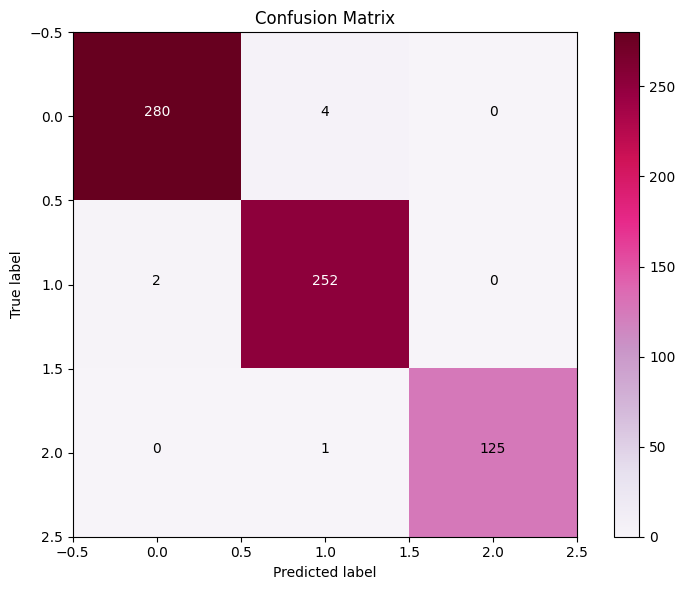

In [67]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()
